<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Variational Autoencoders for Collaborative Filtering on MovieLens dataset. 

This notebook accompanies the paper "*Variational autoencoders for collaborative filtering*" by Dawen Liang, Rahul G. Krishnan, Matthew D. Hoffman, and Tony Jebara, in The Web Conference (aka WWW) 2018 [[Liang, Dawen, et al,2018]](https://arxiv.org/pdf/1802.05814.pdf). In this original paper, the public dataset "20M-MovieLens" is used. However, in our notebook, we used the "1M-MovieLens" dataset because it takes less time for the model to train.

In this notebook, we will show a complete self-contained example of training a Multinomial Variational Autoencoder (described in the original paper) on the public "1M-Movielens" dataset, including data preprocessing, model training and model evaluation.  In the whole notebook we assume that the reader has basic knowledge about VAE [[Kingma et al, 2013]](https://arxiv.org/pdf/1312.6114.pdf). 







# 0 Global Settings and Imports


In [ ]:
# download the necessary libraries 
! pip install tensorflow==2.2.0-rc1
! pip install keras==2.3.1
! pip install papermill

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
import keras

from reco_utils.utils.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.dataset.split_utils import min_rating_filter_pandas
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

from reco_utils.dataset.sparse import AffinityMatrix
from reco_utils.utils.python_utils import binarize
from reco_utils.recommender.vae.multinomial_vae import Mult_VAE

from tempfile import TemporaryDirectory

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

Using TensorFlow backend.


System version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Pandas version: 1.1.3
Tensorflow version: 2.2.0-rc1
Keras version: 2.3.1


In [4]:
# top k items to recommend
TOP_K = 100

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

# Model parameters
HELDOUT_USERS = 600 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 400
BATCH_SIZE = 100

# temporary Path to save the optimal model's weights
tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir, "mvae_weights.hdf5")

SEED = 98765

# 1 Multi-VAE algorithm

__Notations__: The notation used is described below.


$u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$, which is given as an input to the model. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. The click matrix is binarized. It is straightforward to extend it to general count data.

__Multi-VAE Model__: 

For each user u, the model starts by sampling a $K$-dimensional latent representation $\mathbf{z}_u$ from a standard Gaussian prior. The latent representation $\mathbf{z}_u$ is transformed via a non-linear function $f_\theta (\cdot) \in \mathbb{R}^I$ to produce a probability distribution over $I$ items $\pi (\mathbf{z}_u)$ from which the click history $\mathbf{x}_u$ is assumed to have been drawn:

$$
\mathbf{z}_u \sim \mathcal{N}(0, \mathbf{I}_K),  \pi(\mathbf{z}_u) = softmax\{f_\theta (\mathbf{z}_u\},\\
\mathbf{x}_u \sim \mathrm{Mult}(N_u, \pi(\mathbf{z}_u))
$$

$\mathbf{z}_u$ needs to be sampled from an approximate posterior   $q_\phi (\mathbf{z}_u | \mathbf{x}_u )$, which is assumed to be a Gaussian. To compute the gradients the reparametrization trick is used and $\mathbf{z}_u$ is calculated by the formula 
$$
\mathbf{z}_u = \mathbf\mu(x_u)+\mathbf\sigma(x_u) \cdot \mathbf\epsilon
$$

where $\mathbf\epsilon \sim \mathcal{N}(0, \mathbf{I})$ and $ \mathbf\mu(x_u), \sigma(x_u)$ are calculated in encoder.


The objective of Multi-VAE for a single user $u$ is:

$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$

where $q_\phi$ is the approximating variational distribution (inference model/ encoder), and  $p_\theta$ refers to generative model/decoder. The first term is the log-likelohood and the second term is the  Kullback-Leibler divergence term.

Regarding the first term, we use the multinomial log-likelihood formula as proposed in the original paper:

$$\log p_\theta(\mathbf{x}_u | \mathbf{z}_u) = \sum_{i} \mathbf{x}_{ui}\log \mathbf{\pi}_i (z_u) $$

The authors use multinomial likelihood which is intuitively better for modeling implicit feedback and as it is proven by their research work performs better than logistic or gaussian likelihoods, which are typically more popular in the literature. By using multinomial likelihood, they are treating the problem as multi-class classification. As the authors discuss in the paper in section 2.1: "this likelihood rewards the model for putting probability mass on the non-zero entries in $x_u$. But the model has a limited budget of probability mass, since $\pi(z_u)$ must sum to 1; the items must compete for this limited budget. The model should therefore assign more probability mass to items that are more likely to be clicked."

Also, $\mathbf KL-divergence$ is treated as a regularization term as described from[[Higgins et al, 2016]](https://openreview.net/pdf?id=Sy2fzU9gl), [[Burgess et al, 2018]](https://arxiv.org/pdf/1804.03599.pdf) : 


1. When $\mathbf \beta = 1$ corresponds to the original VAE formulation of [[Kingma et al, 2013]](https://arxiv.org/pdf/1312.6114.pdf)

2. Setting $\mathbf \beta > 1$, provides a stronger constraint on the latent bottleneck than in the original VAE formulation. These constraints limit the capacity of $\mathbf z$, which, combined with the pressure to maximise the log likelihood of the training data $\mathbf x$ under the model, should encourage the model to learn the most efficient representation of the data.

3. Setting $\mathbf \beta<1$. In case of recommendation systems our goal is to make good recommendations and not reconstruct the input as close as possible to the initial input, or in other words to maximize the log likelihood. So if we set β<1, then we are weakening the influence of the prior. Futher details can be found in section 2.2 of [[Liang, Dawen, et al,2018]](https://arxiv.org/pdf/1802.05814.pdf).

As a result, for the reasons explained above in 3., the KL-divergence is multiplied by the parameter $\beta \in [0,1]$.

__Selecting β:__ As proposed from the original paper, a simple heuristic methodology is used for selecting  $\mathbf \beta$ . The training process starts with $\mathbf \beta  = 0$, and gradually increase $\mathbf \beta$ to 1. The $\mathbf KL$ term is slowly annealed over a large number of gradient updates to $\mathbf \theta , \phi $. The optimal $\mathbf \beta$ is recorded when the performance of the model reaches the peak. Then using this optimal beta the model is retrained using the same annealing procedure, but $\mathbf \beta$ stops increasing when it reaches the optimal value found in the previous step.

This method works well and with the benefit that it does not require training multiple models with different values of $\mathbf \beta$, which can be time-consuming. This idea is based on the paper 
[[Bowman et al, 2015]](https://arxiv.org/pdf/1511.06349.pdf). This methodology is explained in more detail in section (4).

# 2 Keras implementation of Multi-VAE

For the implementation of the model, Keras package is used. 

For the scope of the project, the MovieLens dataset is used, which is composed of user-to-item interactions and integer ratings from 1 to 5. We convert MovieLens into binarized clicked matrix ( 1: the user liked this movie , 0: the user did NOT like or did NOT watch/rate this movie), and evaluate based on heldout users data.



# 3 Data Preparation 



### 3.1 Load data and split

The data are loaded and splitted into train / validation / test sets following strong generalization: 

- All unique users are splitted into training users and heldout users (i.e. validation and test users)

- By using the lists of these users, the corresponding training data and heldout data are obtained, which are converted to click matrices

- Models are trained using the entire click history of the training users. 

- To evaluate them, part of the click history from heldout data(validation and test) is used to learn the necessary user-level representations for the model. Then, evaluation metrics are computed by looking at how well the model ranks the rest of the unseen click history from the heldout data

#### 3.1.1 Load data

In [5]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

df.head()

100%|██████████| 5.78k/5.78k [00:00<00:00, 14.8kKB/s]


,userID,itemID,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291


In [6]:
df.shape

(1000209, 4)

#### 3.1.2 Data Filtering 



For the data filtering we are using the below 3 steps as recommended from the original paper [[Liang, Dawen, et al,2018]](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o).


So, we have to make sure that :
 - user-to-movie interactions with rating <=3.5 are filtered out. Applying this filtering we make sure that if a movie is rated less than 3.5 from the users that they watched this movie, it will not be contained in the final click matrix. If we do not apply this filter, the final click matrix will be even sparser.
 - the users who clicked less than 5 movies are filtered out. 
 - the movies which are not clicked by any user are filtered out.




In [7]:
# Binarize the data (only keep ratings >= 4)
df_preferred = df[df['rating'] > 3.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 3.5]


# df.head()
df_preferred.head(10)

(575281, 4)


,userID,itemID,rating,timestamp
0,1,1193,5.0,978300760
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291
6,1,1287,5.0,978302039
7,1,2804,5.0,978300719
8,1,594,4.0,978302268
9,1,919,4.0,978301368
10,1,595,5.0,978824268
11,1,938,4.0,978301752
12,1,2398,4.0,978302281


In [8]:
# Keep users who clicked on at least 5 movies
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [9]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 575272 watching events from 6034 users and 3533 movies (sparsity: 2.699%)


#### 3.1.3 Split data

For data slitting we use:
- 600 (~ 10%) users in validation set 
- 600 (~ 10%) users in testing set 
- the rest of them (~ 80%) in training set


Since the model is trained using the click history of the training users, we have to make sure that the movies that exist in the validation and test sets are the movies that exist in the train set. In other words, validation and test set should not contain movies that do not exist in the train set.


In [10]:
unique_users = sorted(df.userID.unique())
np.random.seed(SEED)
unique_users = np.random.permutation(unique_users)

In [11]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - HELDOUT_USERS * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - HELDOUT_USERS * 2) : (n_users - HELDOUT_USERS)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - HELDOUT_USERS):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 6034

Number of training users: 4834

Number of validation users: 600

Number of test users: 600


In [12]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

# train_set/val_set/test_set contain user - movie interactions with rating 4 or 5

Number of training observations:  462827

Number of validation observations:  57388

Number of test observations:  55057


In [13]:
# Obtain list of unique movies used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique movies that rated in training set", unique_train_items.size)

Number of unique movies that rated in training set 3497


In [14]:
# For validation set keep only movies that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  57374

Number of test observations after filtering:  55027


## 3.2 Click matrix generation 

From section 3.1 we end up with 3 datasets train_set, val_set and test_set. As the authors indicate, a click matrix, that contains only 0-s and 1-s, is provided as an input to the model, where each row represents a user and each column represents a movie. 
So, the click matrix contains the preferences of the user, marking each cell with 0 when the user did not enjoy (ratings below 3.5) or did not watch a movie and with 1 when the user enjoyed a movie (ratings above 3.5).

The training set will be a click matrix containing full historicity of all training users. However, the test set and validation set should be splitted into train and test parts. As a result, we get 4 datasets:
- val_data_tr
- val_data_te
- test_data_tr
- test_data_te

'val_data_tr' contains 75% of the the preferred movies (movies marked as 1 in the click matrix) per user.
The rest 25% of the preffered movies are contained into the 'val_data_te'. The same splitting is followed for test set. 

The 'val_data_tr' is given as an input for our model at the end of each epoch. The result of the model is a 'reconstructed_val_data_tr', which contains the movies recommended for each user by the model. In order to evaluate the performance of the model, at the end of each epoch, we compare the 'reconstructed_val_data_tr' (predicted recommendations by the model) with the 'val_data_te' (true movie preferences of each user) using NDCG@k metric. 

For the final evaluation of the model the 'test_data_tr' and 'test_data_te' are being used. As it is described before, the 'test_data_tr' is given as an input for the model and returns the 'reconstructed_test_data_tr' dataset with the recommendations made by the model. Then, the 'reconstructed_test_data_tr' is compared with 'test_data_te' through different metrics:
- MAP
- NDCG@k
- Recall@k
- Precision@k






In [15]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [16]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(4834, 3497)
(600, 3497)
(600, 3497)


In [17]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [18]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=3.5)
val_data = binarize(a=val_data, threshold=3.5)
test_data = binarize(a=test_data, threshold=3.5)

In [19]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=3.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=3.5)

In [20]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=3.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=3.5)

In [21]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
  user_old= i['userID'] # old value 
  item_old=i['itemID'] # old value 

  if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
      user_new=test_map_users.get(user_old) # new value 
      item_new=test_map_items.get(item_old) # new value 
      rating=i['rating'] 
      test_data_te_ratings.at[user_new,item_new]= rating   

  if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
      user_new=val_map_users.get(user_old) # new value 
      item_new=val_map_items.get(item_old) # new value 
      rating=i['rating'] 
      val_data_te_ratings.at[user_new,item_new]= rating   


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    
# test_data_te_ratings  

In [22]:
# Just checking
print(np.sum(val_data))
print(np.sum(val_data_tr))
print(np.sum(val_data_te))

57374.0
43028.0
14346.0


In [23]:
# Just checking
print(np.sum(test_data))
print(np.sum(test_data_tr))
print(np.sum(test_data_te))

55027.0
41278.0
13749.0


# 4 Train Multi-VAE using Keras


__Model Architecture:__

For "MovieLens-1M dataset", we set both the generative function $f_\theta(\cdot)$ and the inference model $g_\phi(\cdot)$ to be 3-layer multilayer perceptron (MLP) with symmetrical architecture.
The generative function is a [70 -> 200 -> n_items] MLP, which means the inference function is a [n_items -> 200 -> 70] MLP. Thus the overall architecture for the Multi-VAE is [n_items -> 200 -> 70 -> 200 -> n_items]. 
Also, Dropout is applied both in encoder and decoder to avoid overfitting. 


Note that this architecture, illustrated in the graph below, is the one that resulted optimal results after investigating multiple architectures both for encoder and decoder.



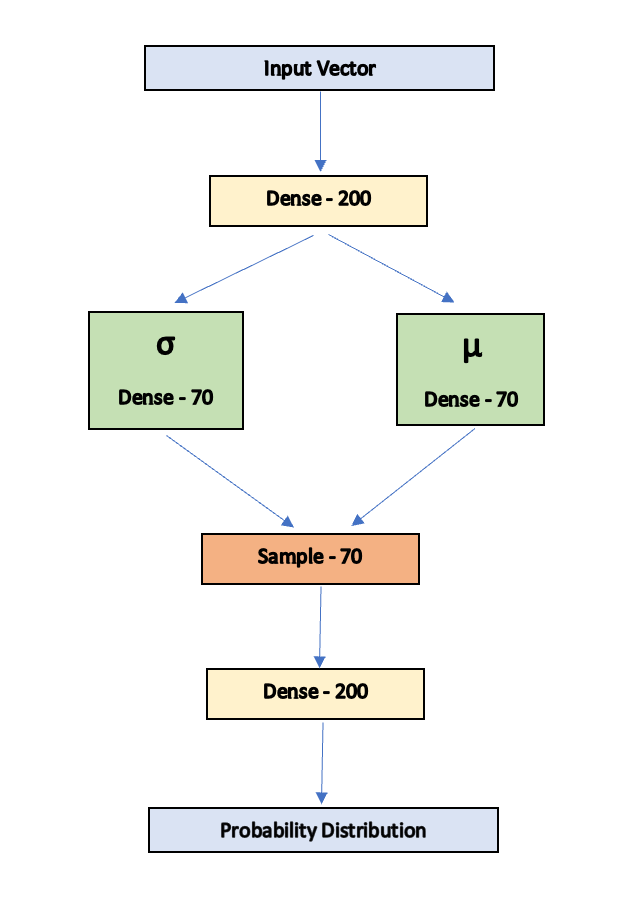

__Model Training:__ 

One of the most interesting parts of the original paper [[Liang, Dawen, et al,2018]](https://arxiv.org/pdf/1802.05814.pdf) is the tuning of $\mathbf \beta$ using annealing. As it is described in section 1, $\mathbf KL- divergence$ is handled as regularization term. $\mathbf KL-divergence$ term is linearly annealed by increasing $\mathbf \beta$ from 0 to 1 slowly over a large number of training steps. From the original paper is proposed that __$\mathbf \beta$ should reach $\mathbf \beta = 1$ at around the 80% of the epochs__ and then $\mathbf \beta$ remains stable at the value of 1. Then optimal beta is found based on the peak value of NDCG@k metric of the validation set.

After finding the optimal beta, we retrain the model with the same annealing but we stop the increase of $\mathbf \beta$ after reaching the value of optimal $\mathbf \beta$ found in the previous step. Alternatively, we can say that we anneal $\mathbf \beta$ until it reaches the anneal_cap (anneal cap = optimal $\mathbf \beta$) at 80% of epochs. 





## 4.1 Multi-VAE without annealing  (initial approach) 

Firstly, for comparison reasons Multi-VAE model is trained using constant $\mathbf \beta$= 1.


In [24]:
model_without_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=False,
                                beta=1.0
                                )

In [ ]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                             x_valid=val_data, 
                             x_val_tr=val_data_tr, 
                             x_val_te=val_data_te_ratings, 
                             mapper=am_val
                             )
print("Took {} seconds for training.".format(t))

Took 664.6268 seconds for training.


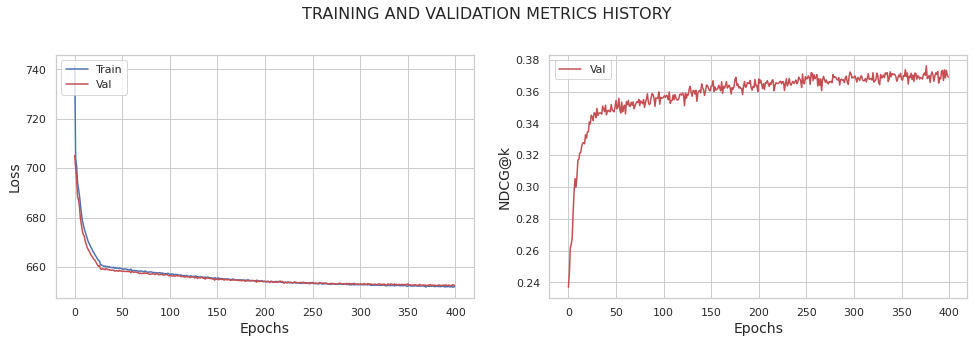

In [ ]:
model_without_anneal.display_metrics()

In [ ]:
ndcg_val_without_anneal = model_without_anneal.ndcg_per_epoch()

#### Prediction and Evaluation of Multi-VAE model using constant 𝛽 = 1.

Evaluate with recommending 10 items.

In [ ]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_1,
      "NDCG@10:\t%f" % eval_ndcg_1,
      "Precision@10:\t%f" % eval_precision_1,
      "Recall@10: \t%f" % eval_recall_1, sep='\n')

Took 4.4747 seconds for prediction.
MAP@10:		0.048516
NDCG@10:	0.430152
Precision@10:	0.403833
Recall@10: 	0.075556


Evaluate with recommending 100 items.

In [ ]:
# Use k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=TOP_K,
                                                    remove_seen=True
                                                    )
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_2 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_ndcg_2 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_precision_2 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_recall_2 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)

print("MAP@100:\t%f" % eval_map_2,
      "NDCG@100:\t%f" % eval_ndcg_2,
      "Precision@100:\t%f" % eval_precision_2,
      "Recall@100: \t%f" % eval_recall_2, sep='\n')

Took 0.4869 seconds for prediction.
MAP@100:	0.133604
NDCG@100:	0.383750
Precision@100:	0.225550
Recall@100: 	0.344727


## 4.2 Multi-VAE with annealing 

Now the annealing procedure for finding the optimal $\mathbf \beta$ is used.

In order to find the optimal $\beta$,  the model is trained using annealing with anneal_cap equal 1.0.




In [25]:
model_with_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                             original_dim=train_data.shape[1], # Number of unique items in the training set
                             intermediate_dim=INTERMEDIATE_DIM, 
                             latent_dim=LATENT_DIM, 
                             n_epochs=EPOCHS, 
                             batch_size=BATCH_SIZE, 
                             k=TOP_K,
                             verbose=0,
                             seed=SEED,
                             save_path=WEIGHTS_PATH,
                             drop_encoder=0.5,
                             drop_decoder=0.5,
                             annealing=True,
                             anneal_cap=1.0,       
                             )

In [26]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, 
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 723.5305 seconds for training.


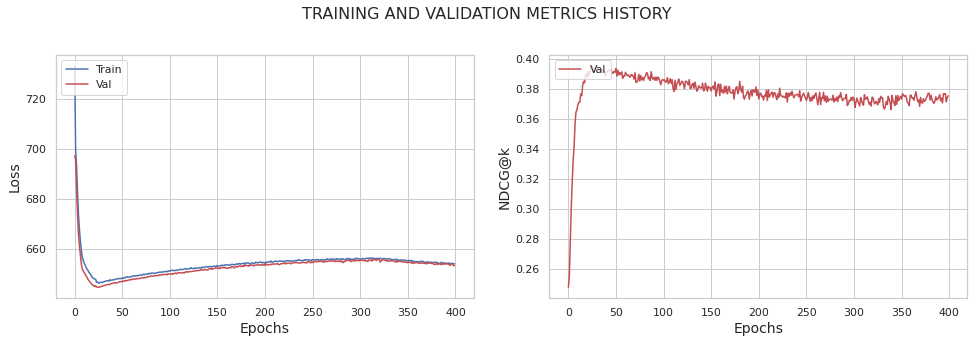

In [27]:
model_with_anneal.display_metrics()


In [28]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [29]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.078125


In [30]:
model_optimal_beta = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                              original_dim=train_data.shape[1], # Number of unique items in the training set
                              intermediate_dim=INTERMEDIATE_DIM,
                              latent_dim=LATENT_DIM,
                              n_epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              k=TOP_K,
                              verbose=0,
                              seed=SEED,
                              save_path=WEIGHTS_PATH,
                              drop_encoder=0.5,
                              drop_decoder=0.5,
                              annealing=True,
                              anneal_cap=optimal_beta,  
                              )

In [31]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, 
                           mapper=am_val
                           )
    
print("Took {} seconds for training.".format(t))


Took 729.9343 seconds for training.


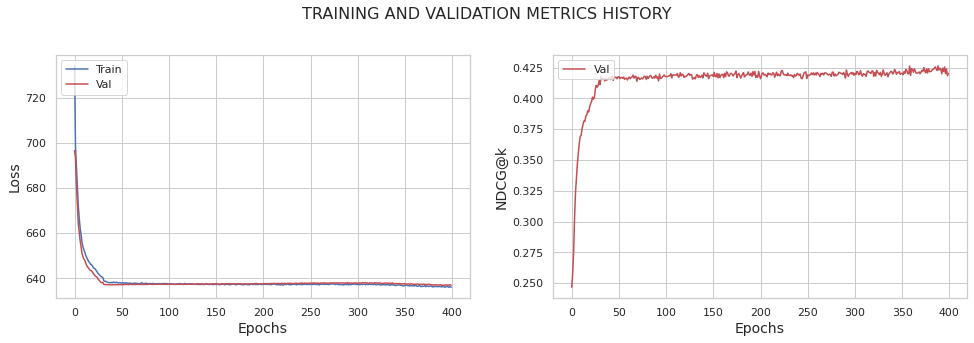

In [32]:
model_optimal_beta.display_metrics()

In [ ]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal $\beta$ with annealing.

Evaluate with recommending 10 items.

In [ ]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 0.7309 seconds for prediction.
MAP@10:		0.060963
NDCG@10:	0.479878
Precision@10:	0.450333
Recall@10: 	0.092874


Evaluate with recommending 100 items.

In [ ]:
# Use k = 100s
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=TOP_K,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_4 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_ndcg_4 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_precision_4 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_recall_4 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)

print("MAP@100:\t%f" % eval_map_4,
      "NDCG@100:\t%f" % eval_ndcg_4,
      "Precision@100:\t%f" % eval_precision_4,
      "Recall@100: \t%f" % eval_recall_4, sep='\n')

Took 0.4572 seconds for prediction.
MAP@100:	0.162202
NDCG@100:	0.430035
Precision@100:	0.244350
Recall@100: 	0.392054


# 5 Conclusion 

Through this notebook is proven that Mult-VAE has competitive performance. 


From the plot below, we can see that the model using annealing outperforms the model without annealing. Specifically, the results of evaluating the test set, for the the 2 different approaches, are:


| Model | NDCG@100 | NDCG@10 | 
| --- | --- | --- | 
| Mult-VAE (wihtout annealing, β=1)| 0.384 | 0.430 | 
| Mult-VAE (with annealing, optimal β)| 0.430 | 0.479 | 


This annealing procedure is used as an efficient way to tune the parameter $\mathbf \beta$. Otherwise, training multiple models using different values of $\mathbf \beta$ can be really time consuming. 



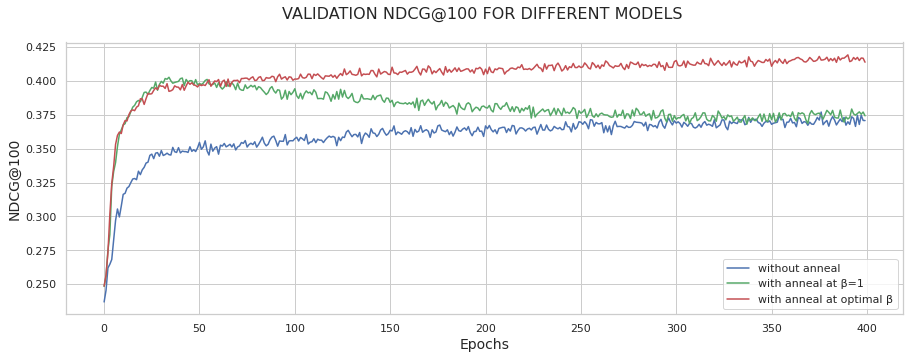

In [ ]:
# Plot setup
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid')

# Plot NDCG@k of validation sets for three models
plt.plot(ndcg_val_without_anneal, color='b', linestyle='-', label='without anneal')
plt.plot(ndcg_val_with_anneal, color='g', linestyle='-', label='with anneal at β=1')
plt.plot(ndcg_val_optimal_beta, color='r', linestyle='-', label='with anneal at optimal β')

# Add plot title and axis names
plt.title('VALIDATION NDCG@100 FOR DIFFERENT MODELS \n', size=16)
plt.xlabel('Epochs', size=14)
plt.ylabel('NDCG@100', size=14)
plt.legend(loc='lower right')

plt.show()

Both for choosing the optimal $\mathbf \beta$ and the optimal model weights the NDCG@100 evaluation metric is used for the validation set (section [4], Paragraph: __Model Training__) as proposed from [[Liang, Dawen, et al,2018]](https://arxiv.org/pdf/1802.05814.pdf). 








Last but not least, it is worth mentioning that for different shuffling of input data, the model may need again hyperparameter tuning or may not work properly since the training dataset may not be indicative for the test set.  

# 6 References

[Liang, Dawen, et al, 2018] [Liang, Dawen, et al. "Variational autoencoders for collaborative filtering." Proceedings of the 2018 World Wide Web Conference. 2018.](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o) 

[Kingma et al, 2013] [Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes."  (2013).](https://arxiv.org/pdf/1312.6114.pdf)

[Burgess et al, 2018] [Burgess, Christopher P., et al. "Understanding disentangling in $\beta $-VAE." (2018)](https://arxiv.org/pdf/1804.03599.pdf)

[Higgins et al, 2016] [Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with a constrained variational framework." (2016).](https://openreview.net/pdf?id=Sy2fzU9gl)


[Bowman et al, 2015] [Samuel R. Bowman, Luke Vilnis, Oriol Vinyals, Andrew M. Dai, Rafal Jozefowicz,
and Samy Bengio. 2015. Generating sentences from a continuous space. (2015).](https://arxiv.org/pdf/1511.06349.pdf)
